# Image Generation with CLIP

### DL Course, Dr. Soleymani

Spring 2025

---
*Full Name:* ...

*SID:* ...

---
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**: 
* This notebook is tested with *Google Colab* free runtime and you can used that for testing your code.
* Ensure all cells are executable
* You can ask your questions on [Quera Class](https://quera.org/course/20754)
* Write clear code.

---

In this notebook, we show that discriminative models have powerful generative capabilities.

## Introduction
Discriminative models map inputs to representations, while generative models synthesize data
from learned latent spaces. This includes models from GANs to diffusion models.
However, these approaches require extensive training on
large datasets.


We will now demonstrate how discriminative models encode rich generative knowledge that can be used through optimization. Discriminative models excel at mapping images to representations $(f : I \rightarrow v)$, but how can we reverse this process $(f^{-1} : v \rightarrow I)$? 
In other words,
> we are given a text $T$ and aim to find an image $I$ that maximizes the score between $T$ and $I$ ($S = \text{score}(T, I)$). How can we determine $I$?

A simple solution is to use gradient ascent, where we compute the gradient of $S$ with respect to $I$ and update $I$ accordingly. Note that we are not updating the model's weights, but rather optimizing the input image.

## Basic setup

In [ ]:
! pip install open_clip_torch
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

## Getting the CLIP models

In [2]:
import clip
import torch
from PIL import Image
import open_clip
import tqdm
import matplotlib.pyplot as plt
from torch.optim import SGD
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class CLIPModel:
    """
    A wrapper class for a CLIP model, handling text and image encoding,
    as well as image normalization.

    Attributes:
        model: The CLIP model used for encoding.
        tokenizer: Tokenizer for processing text inputs.
        mean (Tensor): Mean values for image normalization.
        std (Tensor): Standard deviation values for image normalization.
    """
    def __init__(self, model, tokenizer, preprocess, device='cuda'):
        """
        Initializes the CLIPModel with the given model, tokenizer, and preprocessing pipeline.

        Args:
            model: The CLIP model instance.
            tokenizer: Tokenizer for processing text inputs.
            preprocess: Preprocessing pipeline containing transformations for images.
            device (str, optional): The device to run the model on (default is 'cuda').
        """
        self.model = model
        self.tokenizer = tokenizer
        self.mean = torch.Tensor(preprocess.transforms[-1].mean) \
                         .reshape([1, 3, 1, 1]) \
                         .to(device)
        self.std = torch.Tensor(preprocess.transforms[-1].std) \
                        .reshape([1, 3, 1, 1]) \
                        .to(device)

    def encode_text(self, texts):
        """
        Encodes input text into an embedding using the CLIP model.

        Args:
            texts (list or str): A list of text strings or a single text string.
                - Shape: (batch_size) (list of strings)

        Returns:
            Tensor: Encoded text embeddings.
                - Shape: (batch_size, embedding_dim)
        """
        tokenized_text = self.tokenizer(texts).to(device)
        text_embeddings = self.model.encode_text(tokenized_text)
        return text_embeddings

    def encode_image(self, images):
        """
        Encodes input images into embeddings using the CLIP model after normalization.

        Args:
            images (Tensor): A batch of images as tensors.
                - Shape: (batch_size, 3, height, width)

        Returns:
            Tensor: Encoded image embeddings.
                - Shape: (batch_size, embedding_dim)
        """
        normalized_images = self.normalize_image(images)
        image_embeddings = self.model.encode_image(normalized_images)
        return image_embeddings

    def normalize_image(self, x):
        """
        Normalizes images.

        Args:
            x (Tensor): Input image tensor.
                - Shape: (batch_size, 3, height, width)

        Returns:
            Tensor: Normalized image tensor.
                - Shape: (batch_size, 3, height, width)
        """
        return (x - self.mean) / self.std

    def eval(self):
        """
        Sets the model to evaluation mode.
        """
        self.model.eval()

def img_show(img):
    """
    Display an image.

    Args:
        img (Tensor): The image tensor to display.
            - Shape: (channels, height, width)
    """
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])

Load the CLIP model into our wrapper.

In [ ]:
models_to_load = [
    ("ViT-B-32", "laion400m_e32"),
    ("ViT-B-32", "laion2b_s34b_b79k"),
    ("OpenAI-ViT-B/32", None),
]

models = []
for model_name, pretrained in models_to_load:
    if pretrained is not None:  # openclip models
        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name=model_name,
            pretrained=pretrained
        )

        tokenizer = open_clip.get_tokenizer(model_name)

    else:  # clip models
        model, preprocess = clip.load(model_name.split("OpenAI-")[1])

        tokenizer = clip.tokenize

    print(f"Loaded {model_name} {preprocess}")
    model.to(device)
    models.append(CLIPModel(model, tokenizer, preprocess))

## Optimizing an Image for a Target Representation

Now, let's implement our solution by first defining a function to compute the similarity score.

In [ ]:
def similarity_score(
    image_embeddings,
    text_embeddings,
    text_weights=None,
):
    """
    Computes the similarity score between image and text embeddings using cosine similarity.

    Args:
        image_embeddings (Tensor): A tensor of image embeddings.
            - Shape: (batch_size, embedding_dim)
        text_embeddings (Tensor): A tensor of text embeddings.
            - Shape: (num_texts, embedding_dim)
        text_weights (list or Tensor, optional): A weight factor for text embeddings. Defaults to None.
            - Shape: (num_texts) (if provided)

    Returns:
        Tensor: A tensor of similarity scores for each image.
            - Shape: (batch_size)
    """
    # TODO: Implement cosine similarity between image and text embeddings.
    #    1. Normalize both image and text embeddings along the embedding dimension.
    #    2. Compute cosine similarity by taking the dot product between each image embedding
    #       and each text embedding.
    #    3. If `text_weights` is None, return the mean similarity across all text embeddings
    #       for each image.
    #       Otherwise, multiply the similarity scores by the provided weights before averaging.

    raise NotImplementedError("Implement the similarity_score function as described in the docstring.")

Now this is the core of our method. Here we define an optimizer on an initial random image.

We then denoise this image to generate a coherent final image by optimizing it step by step.

In [ ]:
def optimize_image(
    model,
    target_text,
    image_size=224,
    learning_rate=1e-1,
    num_steps=100
):
    """
    Optimizes an image to match a given target text representation using a pre-trained model.

    Args:
        model: The pre-trained CLIP model used to encode images and text.
        target_text (str): The target text description to guide the image optimization.
        image_size (int, optional): The resolution of the generated image. Defaults to 224.
        learning_rate (float, optional): The learning rate for the optimizer. Defaults to 1e-1.
        num_steps (int, optional): The number of optimization steps. Defaults to 100.

    Returns:
        torch.Tensor: The optimized image tensor with shape [1, 3, image_size, image_size].
    """
    # TODO: Initialize a random image tensor with shape [1, 3, image_size, image_size]

    # TODO: Create an optimizer to optimize the image tensor.

    # TODO: Implement the optimization loop (for num_steps iterations):
    # - Get the image embedding by passing the image through the model using model.encode_image().
    # - Get the text embedding by passing the target_text through the model using model.encode_text().
    # - Compute the similarity score between image and text embeddings using cosine similarity.
    # - Compute the loss as the negative of the similarity score (to maximize similarity).
    # - Backpropagate the loss and update the image using optimizer.step().
    # - Return the optimized image.

    raise NotImplementedError("Implement the optimize_image function based on the above description.")

In [7]:
generated_image = optimize_image(models[0], "a photo of a cat")

Step 1/100, Loss: -0.09076951444149017
Step 10/100, Loss: -0.4392561912536621
Step 20/100, Loss: -0.5957977771759033
Step 30/100, Loss: -0.6690686345100403
Step 40/100, Loss: -0.7186994552612305
Step 50/100, Loss: -0.718701958656311
Step 60/100, Loss: -0.7794708609580994
Step 70/100, Loss: -0.8013465404510498
Step 80/100, Loss: -0.8196672797203064
Step 90/100, Loss: -0.8409364223480225
Step 100/100, Loss: -0.8639918565750122


### Resulting image

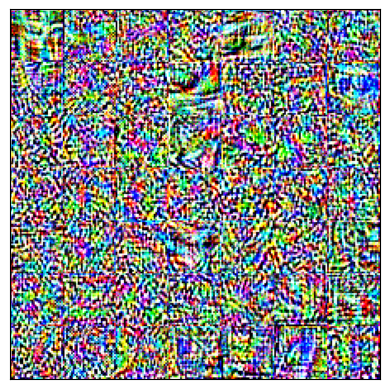

In [8]:
img_show(generated_image[0].detach().cpu())

Well, the model identifies the image as a cat—but is it really? Although the image achieves a high similarity score, it doesn’t truly resemble a cat. This optimized image, which tricks the model into making an incorrect prediction, is known as an **adversarial image**.  

To better understand why this image was generated, take a look at the following illustration:

![mapping-between-images-and-embeddings.png](https://i.postimg.cc/NG2ZbP9J/mapping-between-images-and-embeddings.png)

A region of all images corresponding to a {text, image} embedding contains
interpretable images as well as noise-like adversarial patterns.
Reconstructing an image from an embedding typically leads to
such a degenerate noisy image.

We now need a method to ensure that the reconstructed image lies within the interpretable region of the manifold. Upon reviewing the generated image, you'll notice that it exhibits high-frequency patterns. In the following sections, we will modify the optimization process to avoid the degenerate high-frequency solutions commonly seen in adversarial examples.

## Multi-Resolution Optimization
We decompose the optimization across multiple scales – a choice that proves surprisingly powerful in guiding solutions toward natural images.
We break the degeneracy by decomposing the optimization across multiple scales. Instead of directly optimizing pixels,
we express the image as a sum of resolution components:
$$
I = \frac{1}{2} + \frac{1}{2} \tanh \left(\sum_{r \in \rho} \text{resize}_{224}(P_r)\right) \qquad (1)
$$
where $P_r \in \mathbb{R}^{r \times r \times 3}$ represents the image component at
resolution $r$, and $\rho$ spans from $1 \times 1$ to $224 \times 224$. The tanh
transformation maps unbounded optimization values to valid
pixel intensities while maintaining gradient flow.

The optimization objective becomes:
$$
\sum_{i,j} \frac{\partial \text{score}_i(\text{augment}_j(I(P_1, \ldots, P_{224})))}{\partial (P_1, \ldots, P_{224})}
$$

where $i$ indexes multiple CLIP models and $j$ indexes augmentations. This formulation has several key properties:
1. Components are optimized simultaneously across all resolu-
tions
2. Gradients naturally distribute across scales based
on their importance
3. High-frequency adversarial patterns are suppressed by scale decomposition.

## Image Converters

In [ ]:
def raw_to_real_image(raw_image):
    """
    Converts a raw image tensor to a real image tensor by applying a hyperbolic tangent transformation
    and scaling the result to the range [0, 1].

    Args:
        raw_image (Tensor): The raw image tensor to be converted.
            - Shape: (batch_size, channels, height, width)

    Returns:
        Tensor: The transformed real image tensor with values in the range [0, 1].
            - Shape: (batch_size, channels, height, width)
    """
    # TODO: Apply the hyperbolic tangent (tanh) transformation to the raw image tensor.
    # - The tanh function outputs values in the range [-1, 1]. After applying tanh,
    #   scale and shift the result to bring the values to the range [0, 1].
    # - The formula for scaling is: 0.5 * tanh(raw_image) + 0.5

    raise NotImplementedError("Implement the raw_to_real_image function.")


def real_to_raw_image(real_image, eps=1e-5):
    """
    Converts a real image tensor to a raw image tensor by clipping the real image values to a safe range
    and applying the inverse hyperbolic tangent transformation.

    Args:
        real_image (Tensor): The real image tensor to be converted.
            - Shape: (batch_size, channels, height, width)
        eps (float, optional): A small value used to prevent instability near 0 or 1 during arctanh calculation.
            Defaults to 1e-5.

    Returns:
        Tensor: The transformed raw image tensor with values in the range [-1, 1].
            - Shape: (batch_size, channels, height, width)
    """
    # TODO: 
    # - Clip the input `real_image` to the range [eps, 1 - eps] to prevent instability
    # - Reverse the transformation applied by the 'raw_to_real_image' function
    
    raise NotImplementedError("Implement the real_to_raw_image function.")

## Augmentation tools
As seen in the equation above, we need to augment the image during optimization. This ensures that small changes in the picture do not significantly affect the score, which is a characteristic of natural images.

In [ ]:
def add_jitter(x, size=3):
    """
    Adds random jitter to an image by shifting it horizontally and vertically
    within the specified range.

    Args:
        x (Tensor): The input image tensor to which jitter will be applied.
            - Shape: (batch_size, channels, height, width)
        size (int, optional): The maximum number of pixels to shift in either direction.
            Default is 3.

    Returns:
        Tensor: The image tensor with random shifts applied.
            - Shape: (batch_size, channels, height, width)
    """
    # TODO: 
    # - Generate a random horizontal shift within the range [-size, size]
    # - Apply the shifts to the input tensor `x`.
    
    raise NotImplementedError("Implement the add_jitter function based on the description.")


def center_crop(x, out_size=224):
    """
    Crops the central region of an image tensor to a specified output size.

    Args:
        x (Tensor): The input image tensor to be cropped.
            - Shape: [batch_size, channels, height, width]
        out_size (int, optional): The target output size for both height and width.
            Default is 224.

    Returns:
        Tensor: The cropped image tensor with the specified output size.
            - Shape: [batch_size, channels, out_size, out_size]
    """
    # TODO
    raise NotImplementedError("Implement the center_crop function based on the description.")


def add_noise(x, scale=0.1):
    """
    Adds random noise to an image tensor by adding uniform noise scaled by the specified factor.

    Args:
        x (Tensor): The input image tensor to which noise will be added.
            - Shape: (batch_size, channels, height, width)
        scale (float, optional): The scaling factor for the noise. Default is 0.1.

    Returns:
        Tensor: The noisy image tensor.
            - Shape: (batch_size, channels, height, width)
    """
    # TODO
    raise NotImplementedError("Implement the add_noise function based on the description.")


def augment_image(
    image_in: torch.Tensor,
    count: int = 1,
    jitter_scale: float = 3,
    noise_scale: float = 0.1,
    clip: bool = True
) -> torch.Tensor:
    """
    Performs multiple augmentations on an input image, including jitter, center cropping, and noise addition.
    The function can generate multiple augmented images if requested.

    Args:
        image_in (Tensor): The input image tensor to be augmented.
            - Shape: (batch_size, channels, height, width)
        count (int, optional): The number of augmented images to generate. Default is 1.
        jitter_scale (float, optional): The scale of random jitter to apply. Default is 3.
        noise_scale (float, optional): The scale of noise to add. Default is 0.1.
        clip (bool, optional): Whether to clip the values of the resulting image to the range [0, 1]. Default is True.

    Returns:
        Tensor: The augmented image tensor with the specified number of augmented images.
            - Shape: (count * batch_size, channels, out_size, out_size)
    """
    
    # TODO
    raise NotImplementedError("Implement the augment_image function based on the description.")

## Image Generation using Multi-Resolution Optimization
In this stage, we will implement the `generate_image` method, which will be used for all five tasks discussed in the following sections.

In [ ]:
def generate_image(
    models,
    text_weight_pairs,
    source_image=None,
    original_resolution=224,
    large_resolution=224 + 2 * 56,  # adding the buffer on the side
    resolutions=range(1, 336 + 1),
    batch_size=32,
    lr=2e-1,
    steps=100,
    jitter_scale=56,
    noise_scale=0.2,
    augmentation_copies=32,
    step_to_show=10,  # how often to show the image during generation
    num_generations=1,
    guiding_images=None,
    image_weights=None,
    inpainting_mask=None,
):
    """
    Generates an image by optimizing the input image using a set of models and target text-image pairs.

    Args:
        models (list): A list of models to use for image generation.
        text_weight_pairs (list of tuples): A list of (weight, text) pairs for guiding the image generation.
        source_image (Tensor, optional): The starting image for generation. If None, a random image is used.
            - Shape: (num_sources, channels, height, width)
        original_resolution (int, optional): The original resolution of the image. Default is 224.
        large_resolution (int, optional): The resolution of the image, including the buffer. Default is 336.
        resolutions (range or list, optional): A range or list of resolutions to generate. Default is range(1, 337).
        batch_size (int, optional): The batch size used for optimization. Default is 32.
        lr (float, optional): The learning rate for optimization. Default is 2e-1.
        steps (int, optional): The number of optimization steps. Default is 100.
        jitter_scale (int, optional): The scale of jitter applied to the images during augmentation. Default is 56.
        noise_scale (float, optional): The scale of noise added to the images during augmentation. Default is 0.2.
        augmentation_copies (int, optional): The number of augmentations to create at once for gradient updates. Default is 32.
        step_to_show (int, optional): The frequency of steps at which to display the generated image. Default is 10.
        num_generations (int, optional): The number of images to generate. Default is 1.
        guiding_images (Tensor, optional): Additional guiding images for the generation process.
            - Shape: (num_guiding_images, channels, height, width)
        image_weights (list, optional): Weights for the guiding images.
        inpainting_mask (Tensor, optional): A mask used for inpainting during the generation process.
            - Shape: (num_generations, channels, height, width)

    Returns:
        tuple: A tuple containing:
            - collected_images (list): A list of images generated at each step.
            - components (list): The component images for each resolution.
    """
    target_texts = [x[1] for x in text_weight_pairs]
    target_weights = [x[0] for x in text_weight_pairs]

    # Just making sure no duplicates and sorted
    resolutions = sorted(set(resolutions))
    print(f"Resolutions = {resolutions}")

    guiding_embeddings, guiding_weights = get_guidance(
        models, guiding_images, image_weights, target_texts, target_weights)

    starting_image = get_starting_image(
        source_image, large_resolution, num_generations)

    batch_count = int(np.ceil(augmentation_copies / batch_size))
    
    
    raw_starting_image = real_to_raw_image(starting_image)
    components = None
    # TODO:
    # - Initialize individual resolutions with zero tensors
    # - Define your preferred optimizer and scheduler

    collected_images = []
    for step in tqdm.tqdm(range(steps)):
        # TODO:
        # - Use `F.interpolate` to upsample all components to the `large_resolution`
        # - Sum all upsampled components
        # - Apply `register_hook` to enforce the inpainting mask by zeroing gradients where the mask is zero

        losses = []
        for it in range(batch_count):

            for model, model_guiding_embeddings in zip(models, guiding_embeddings):
                model.eval()
                # TODO:
                # - Add the sum of components to the raw starting image
                # - Convert the result back to a real image
                # - Apply augmentations to the resulting image
                # - Encode all augmented images
                # - Compute similarity score between encoded images and guidance embeddings
                # - Calculate the loss based on similarity scores
                # - Call `backward()` on the loss
            
        # TODO:
        # - Update components using the optimizer
        # - Step the scheduler to update the learning rate
        # - Append the current generated image to `collected_images`



        if step % step_to_show == 0:
            # TODO:
            # - Print the current step, loss value, and L-infinity norm of the summed components

            plot_collected_images(num_generations, collected_images)

    return collected_images, components


def get_starting_image(source_image, large_resolution, num_generations):
    """
    Returns the starting image for the generation process.

    Args:
        source_image (Tensor, optional): The initial image to use as the starting point.
            - Shape: (num_sources, channels, height, width]
        large_resolution (int): The resolution of the output image.
        num_generations (int): The number of images to generate.

    Returns:
        Tensor: The starting image tensor, possibly repeated for multiple generations.
            - Shape: (num_generations, channels, large_resolution, large_resolution)
    """

    # TODO:
    # - If source_image is None, create a tensor filled with 0.5
    # - Otherwise, replicate source_image to match num_generations
    # - Return the starting image tensor
    
    raise NotImplementedError("Implement the get_starting_image function based on the description.")


def plot_collected_images(num_generations, collected_images):
    """
    Plots the collected images during the generation process.

    Args:
        num_generations (int): The number of generated images to display.
        collected_images (list): A list of images generated at each step.
            Each entry in the list is a tensor of shape (num_generations, channels, height, width).
    """
    plt.figure(figsize=(3 * 5.5, num_generations * 5), dpi=75)
    for i in range(num_generations):
        plt.subplot(num_generations, 3, 1 + i * 3)
        img_show(collected_images[0][i])
        plt.title("Source image")

        plt.subplot(num_generations, 3, 2 + i * 3)
        img_show(collected_images[-1][i])
        plt.title("Generated image")

        plt.subplot(num_generations, 3, 3 + i * 3)
        img_show(
            0.5 + (collected_images[-1][i] - collected_images[0][i]))
        plt.title("Residual image")

    plt.show()


def get_guidance(models, guiding_images, image_weights, target_texts, target_weights):
    """
    Computes the guidance embeddings (text and image) for the generation process.

    Args:
        models (list): A list of models used to encode the text and images.
        guiding_images (Tensor, optional): Additional guiding images used for the generation.
            - Shape: (num_guiding_images, channels, height, width)
        image_weights (list, optional): Weights for the guiding images.
        target_texts (list of str): The target texts for the generation.
        target_weights (list of float): The weights for each target text.

    Returns:
        tuple: A tuple containing:
            - guiding_embeddings (Tensor): The combined text and image embeddings.
                Shape: (num_models, num_guidings, embeddings_dim)
            - guiding_weights (list): The weights for each guidance.
    """
    # TODO:
    # - If `guiding_images` is None, return only the text embeddings and target_weights
    # - Otherwise:
    #     - Encode `guiding_images` with each model
    #     - Concatenate the resulting image embeddings with the text embeddings
    #     - Return the concatenated embeddings along with their weights

    raise NotImplementedError("Implement the get_guidance function based on the description.")

## Chosing the Models to Use in the Ensemble
You can try different model combinations and observe how they affect the results of the following tasks.

In [ ]:
chosen_model_ids = [0, 1, 2]
models = [x for i, x in enumerate(models) if i in chosen_model_ids]

## Plotting Tools
The following functions help us visualize the results for further analysis.

In [13]:
def display_images(
    collected_images,
    original_res=224,
    large_res=336,
    guiding_image=None,
    starting_image=None,
):
    """
    Displays the starting image, guiding image, and generated images side by side.

    Args:
        collected_images (list of Tensor): A list of tensors representing the generated images at each step.
            Each tensor should have the shape (num_generations, channels, height, width).
        original_res (int, optional): The resolution of the images to display. Default is 224.
        large_res (int, optional): The resolution of the images, including the buffer. Default is 336.
        guiding_image (Tensor, optional): The guiding image used during the generation process.
            - Shape: (channels, height, width)
        starting_image (Tensor, optional): The starting image used for generation.
            - Shape: (channels, height, width)
    """
    num_images = collected_images[-1].shape[0] + (guiding_image != None) + (starting_image != None)

    plt.figure(figsize=(num_images * 224 / 100, 224 / 100), dpi=112)
    subplot_idx = 1

    begin = (large_res - original_res) // 2
    end = begin + original_res

    if starting_image is not None:
        plt.subplot(1, num_images, subplot_idx)
        img_show(starting_image[0].detach().cpu())
        plt.title("Starting image", fontsize=8)
        subplot_idx += 1

    if guiding_image is not None:
        plt.subplot(1, num_images, subplot_idx)
        img_show(guiding_image[0].detach().cpu())
        plt.title("Guiding image", fontsize=8)
        subplot_idx += 1

    for i, image in enumerate(collected_images[-1]):
        plt.subplot(1, num_images, subplot_idx)
        img_show(image[:, begin:end, begin:end].detach().cpu())
        if len(collected_images[-1]) == 1:
            plt.title(f"Generated image", fontsize=8)
        else:
            plt.title(f"Generated image v{i + 1}", fontsize=8)
        subplot_idx += 1

    plt.show()

In [14]:
def visualize_individual_resolutions(
    components,
    version_i=0,
    selected_resolutions=[1, 2, 4, 8, 16, 32, 64],
    large_resolution=336,

):
    """
    Visualizes the components of a generated image at different resolutions, both at their original resolution
    and interpolated to a larger resolution. This helps to understand the contributions of different resolutions
    to the overall generated image.

    Args:
        components (list of Tensor): A list of tensors representing the image components at various resolutions.
            Each tensor is of shape [num_generations, channels, height, width], with different resolutions.
        version_i (int, optional): The index for the version of the generated image to display. Defaults to 0.
        selected_resolutions (list of int, optional): The list of resolutions to visualize. Each resolution in
            the list should correspond to a downsampled version of the image. Default is [1, 2, 4, 8, 16, 32, 64].
        large_resolution (int, optional): The resolution to which the components will be interpolated for comparison.
            Default is 336.
    """
    plt.figure(figsize=(3 * len(selected_resolutions), 3 * 2))
    for component in components:
        if component.shape[2] in selected_resolutions:

            plt.subplot(2, len(selected_resolutions), selected_resolutions.index(
                component.shape[2]) + 1)

            data = component[version_i]
            data = raw_to_real_image(data).detach(
            ).cpu()
            data = data - torch.min(data)
            data = data / torch.max(data)
            img_show(data)
            plt.title(f"r = {component.shape[2]}")

            plt.subplot(2, len(selected_resolutions), selected_resolutions.index(
                component.shape[2])+1+len(selected_resolutions))

            data_interpolated = F.interpolate(component, size=(
                large_resolution, large_resolution), mode='bicubic')

            data = raw_to_real_image(data_interpolated[version_i]).detach(
            ).cpu()
            data = data - torch.min(data)
            data = data / torch.max(data)
            img_show(data)

    plt.show()

## Task 1: Image Generation From Text
For the first task, we aim to provide the model with a prompt and generate the corresponding image. The key idea is that we can use multiple text inputs with different weights—including negative weights! Feel free to experiment with different texts.

In [15]:
text_weight_pairs = [
    (1.0, "a photo of swiss mountain valley"),
    (-0.3, 'cloudy'),
    (0.3, "several homes, lush forest, rivers"),
    (0.3, "humans, peoples")
]

In [ ]:
collected_images, components = generate_image(
    models,
    text_weight_pairs,
)

### Resulting Image

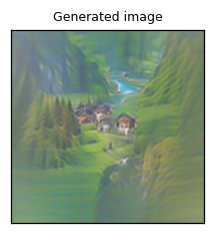

In [17]:
display_images(
    collected_images,
)

### Individual Resolutions
An image is expressed as a sum of components at increasing resolutions, from $1 \times 1$ to $224 \times 224$.

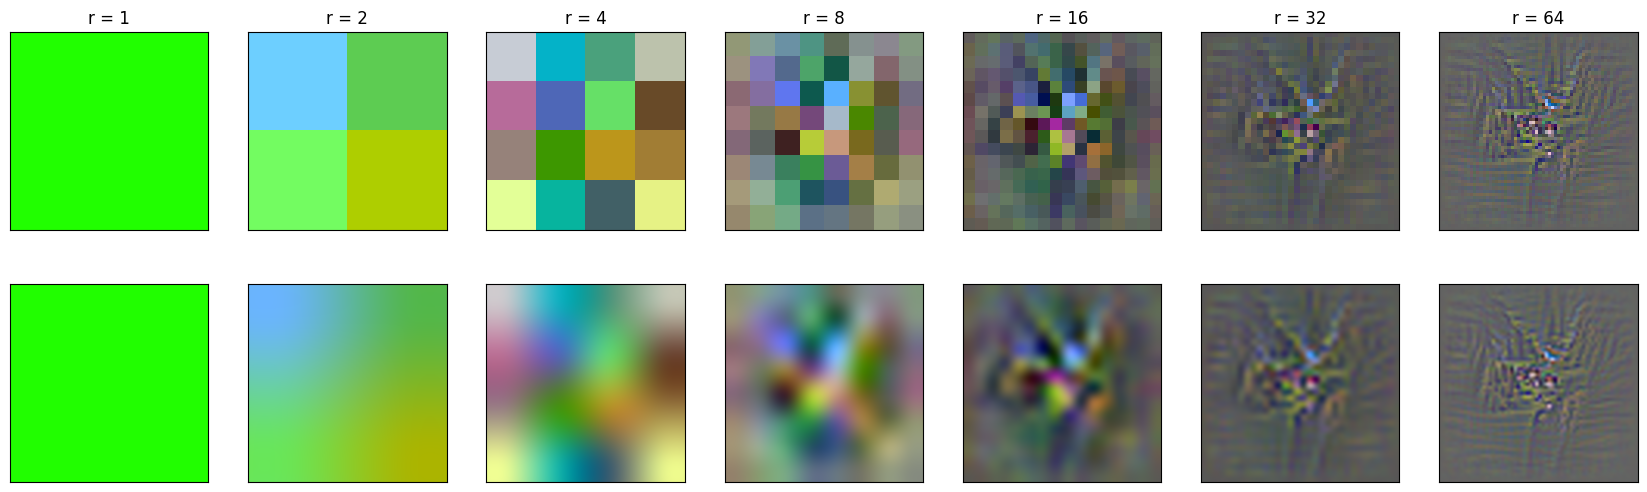

In [18]:
visualize_individual_resolutions(components)

## Task 2: Generation Over Multiple Runs
Now, we aim to generate multiple images simultaneously for a given text.

In [ ]:
text_weight_pairs = [
    (1.0, "a beautiful photo of  Mount Pinatubo eruption., detailed"),
    (-0.3, "obscured crater"),
    (0.3, "highly realistic"),
    (-0.3, "multiple exposure"),
]

In [ ]:
collected_images, components = generate_image(
    models,
    text_weight_pairs,
    num_generations=4,
)

### Resulting Images

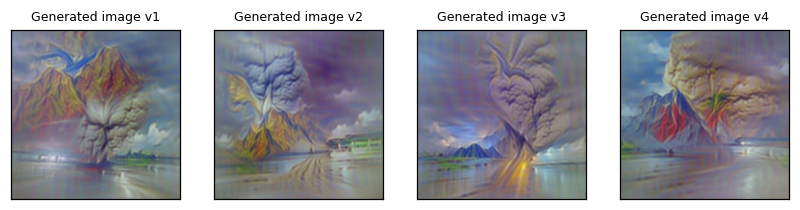

In [21]:
display_images(
    collected_images,
)

## Task 3: "Style" Transfer

We're aiming to transfer the style of one image onto another. Do you have any suggestions on how to approach this?

(Take a moment to think about it before continuing.)

Our approach is to use the original image as the *starting image*, and the image whose style we want to transfer as the *guiding image*.  
We then gradually update the starting image so that its embedding becomes closer to that of the guiding image. As a result, the final image ends up being a blend of both—the content of the original image and the style of the guiding image.


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

        self.transform = transforms.Compose([
            transforms.Resize(224),  # Resize shorter side to 224, maintain aspect ratio
            transforms.CenterCrop(224),  # Crop the center 224x224
            transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        tensor = self.transform(image)
        return tensor

def load_images(image_paths, batch_size=32):
    """
    Load images from list of paths and return batched tensor

    Args:
        image_paths (list): List of paths to image files
        batch_size (int): Size of batches to return

    Returns:
        DataLoader that yields tensors of shape [batch_size, 3, 224, 224]
    """
    dataset = ImageDataset(image_paths)
    dataloader = DataLoader(dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4)
    return dataloader

### Starting Image

In [ ]:
! mkdir -p assets && wget "https://www.noesnest.com/wp-content/uploads/sites/14/2020/03/san-francisco-at-night.jpg" -O assets/3-starting-image.jpg

image_paths = [
    "assets/3-starting-image.jpg"
]

loader = load_images(image_paths)

starting_image = next(iter(loader))

large_res = 336

eps = 0.1 # to offset the image from the ends of the brigthness range
starting_image = starting_image * (1 - 2 * eps) + eps

# adding padding to make it 336 size in total (not resizing, padding)
pad_height = (large_res - starting_image.shape[2]) // 2
pad_width = (large_res - starting_image.shape[3]) // 2

starting_image = F.pad(
    starting_image,
    (pad_width, pad_width, pad_height, pad_height),
    mode="constant",
    value=0.5
)

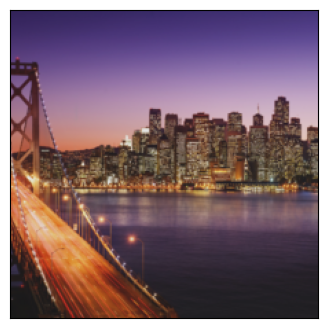

In [24]:
offset = (large_res - 224) // 2
plt.figure(figsize=(4 * starting_image.shape[0], 4))
for i in range(starting_image.shape[0]):
    plt.subplot(1, starting_image.shape[0], i + 1)
    img_show(starting_image[i][:, offset:-offset, offset:-offset])

plt.show()

### "Style" Guiding Image

In [ ]:
! wget "https://i.postimg.cc/44hZvX9K/majestic-medieval-castle-stockcake.jpg" -O assets/3-guiding-image.png
image_paths = [
    "assets/3-guiding-image.png"
]

loader = load_images(image_paths)
guiding_image = next(iter(loader))

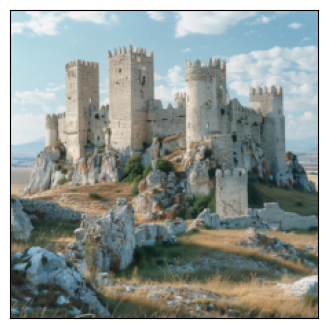

In [26]:
plt.figure(figsize=(4 * guiding_image.shape[0], 4))
for i in range(guiding_image.shape[0]):
    plt.subplot(1, guiding_image.shape[0], i + 1)
    img_show(guiding_image[i])

plt.show()

### Combining the Two

In [ ]:
collected_images, components = generate_image(
    models,
    text_weight_pairs=[],
    guiding_images=guiding_image,
    source_image=starting_image.detach().cpu(),
)

### Resulting Image

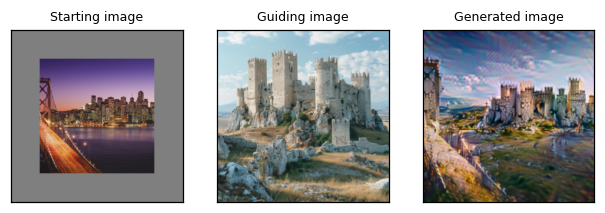

In [28]:
display_images(
    collected_images,
    guiding_image = guiding_image,
    starting_image = starting_image
)

## Task 4: Reconstructing an Image from Its Embedding

In this section, we explore whether our gradient-based approach can be used to simulate image reconstruction. Do you have any suggestions?

(Take a moment to think about this before continuing.)

We use the target image as the *guiding image*. To further support the optimization process, we can also provide a well-crafted prompt to guide the reconstruction more effectively.

### Getting the Image to Reconstruct

In [ ]:
! wget "https://i.postimg.cc/KYLtvPNn/4-guiding-image.png" -O assets/4-guiding-image.png

image_paths = [
    "assets/4-guiding-image.png"
]

loader = load_images(image_paths)
guiding_image = next(iter(loader))

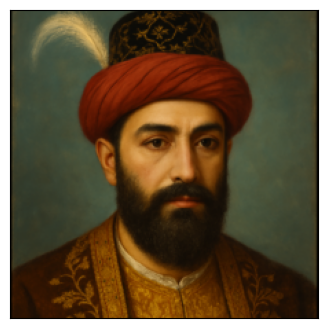

In [ ]:
plt.figure(figsize=(4 * guiding_image.shape[0], 4))
for i in range(guiding_image.shape[0]):
    plt.subplot(1, guiding_image.shape[0], i + 1)
    img_show(guiding_image[i])

plt.show()

### Reconstructing the Image

In [ ]:
# helping the reconstruction with a content agnostic set of prompts
text_weight_pairs = [
  (0.6,"cohesive single subject"),
  (-0.6, "multiple exposure"),
]

collected_images, _ = generate_image(
  models,
  text_weight_pairs = text_weight_pairs,
  guiding_images = guiding_image,
)

## Resulting image

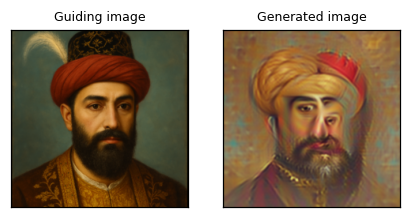

In [32]:
display_images(
    collected_images,
    guiding_image = guiding_image,
)

## Task 5: Inpainting

To achieve a more visually appealing result, we aim to edit a specific part of the image. This feature is already supported by the `generate_image` function.

### Starting Image

In [ ]:
! wget "https://www.noesnest.com/wp-content/uploads/sites/14/2020/03/san-francisco-at-night.jpg" -O assets/5-starting-image.jpg

image_paths = [
    "assets/5-starting-image.jpg"
]

loader = load_images(image_paths)

starting_image = next(iter(loader))

large_res = 336

eps = 0.1 # to offset the image from the ends of the brigthness range
starting_image = starting_image * (1 - 2 * eps) + eps

# adding padding to make it 336 size in total (not resizing, padding)
pad_height = (large_res - starting_image.shape[2]) // 2
pad_width = (large_res - starting_image.shape[3]) // 2

starting_image = F.pad(
    starting_image,
    (pad_width, pad_width, pad_height, pad_height),
    mode="constant",
    value=0.5
)

### Inpainting Mask
To customize the image editing process, you can specify your own mask and prompt to guide the changes.

In [34]:
text_weight_pairs = [
    (1.0, "a vast night sky filled with countless twinkling stars"),
    (0.3, "the stars vary in size and brightness"),
]

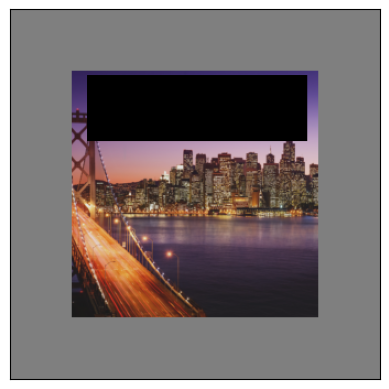

In [ ]:
mask = torch.zeros_like(starting_image)
mask[:, :, 60:120,70:270] = 1

img_show((starting_image * (1 - mask))[0])

### Inpainting

In [ ]:
collected_images, components = generate_image(
    models,
    text_weight_pairs,
    inpainting_mask=mask.to(device),
    source_image = starting_image.detach().cpu(),
)

### Resulting Image

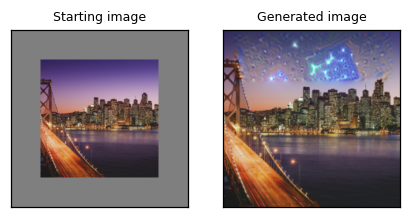

In [38]:
display_images(
    collected_images,
    starting_image=starting_image
)